In [45]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from rl_es.setting import ENVIRONMENTS


from scipy.signal import savgol_filter


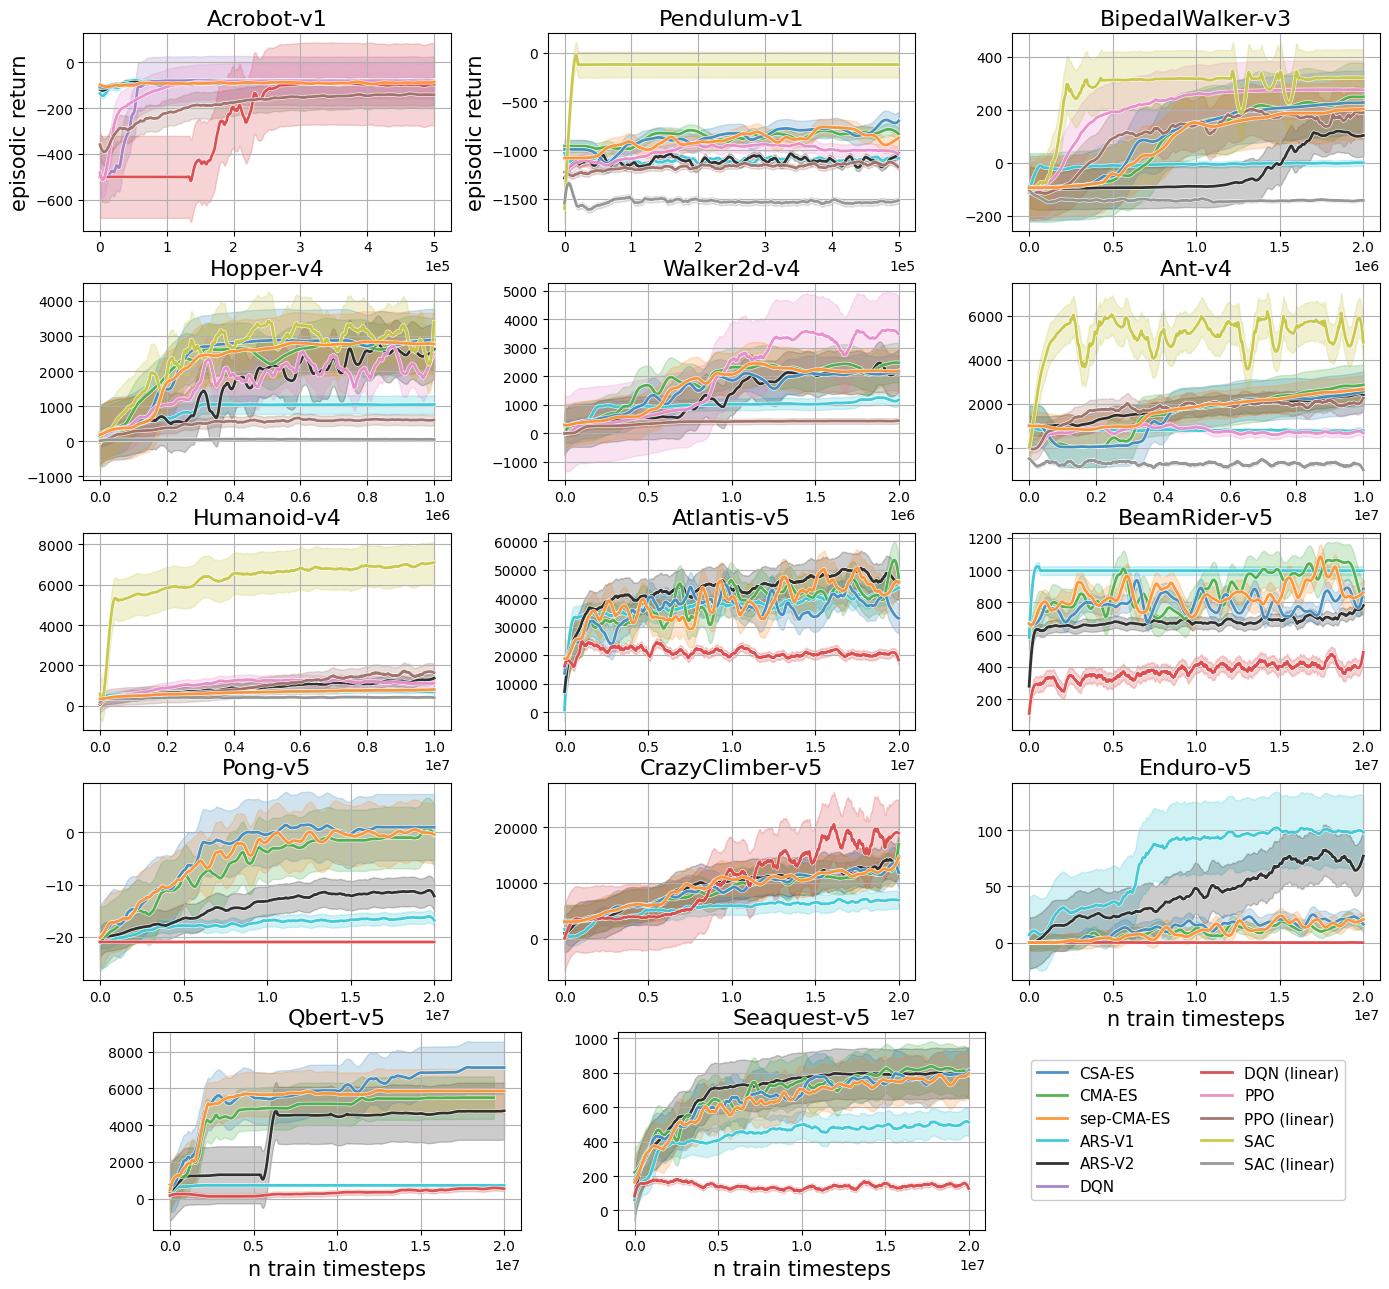

In [9]:
time_measure = 'n_train_timesteps'
max_reward = pd.DataFrame()
rl_data = pd.read_pickle(f"../data2/rl_data3.pkl")
# rl_data = rl_data[rl_data.method.str.endswith("small")]

col = {x:y for x, y in zip(
    (
        "csa", 
        "sep-cma-es",
        "cma-es",
        "dqn_small",
        "dqn_large",
        "ppo_small",
        "ppo_large",
        "sac_small",
        "sac_large",
        "ars",
        "ars-v2"
     )
    , list(colors.TABLEAU_COLORS.keys()) + ["k"])}

bounds = {
    "CartPole-v1": (0, 500)
}

def get_bounds(name):
    if b:=bounds.get(name):
        return b
    lb, ub = -np.inf, np.inf        
    return lb, ub

def pretty(label):
    return (label
            .replace("_large", "")
            .replace("csa", "csa-es")
            .upper() 
            .replace("_SMALL", " (linear)")
            .replace("SEP-", "sep-")
           )
    
f, axes = plt.subplots(5, 3, figsize=(14, 13))

f.delaxes(axes.ravel()[-1])

summary = pd.DataFrame()
handles, labels = [], []
for i, ((env_name, min_timesteps), ax) in enumerate(zip((
    # ("CartPole-v1", 5e5),
    # ("LunarLander-v2", 5e5),
    # ("Swimmer-v4", 5e5),
    # ("HalfCheetah-v4", 3e6),
    # # ("Boxing-v5", 1e8),
    # ("SpaceInvaders-v5", 1e8),
    
    ("Acrobot-v1", 5e5),
    ("Pendulum-v1", 5e5),
    ("BipedalWalker-v3", 2e6),
    
    ("Hopper-v4", 1e6),
    ("Walker2d-v4", 2e6),
    ("Ant-v4", 1e7),
    ("Humanoid-v4", 1e7),
    
    ("Atlantis-v5", 2e7),
    ("BeamRider-v5", 2e7),
    ("Pong-v5", 2e7),
    ("CrazyClimber-v5", 2e7),
    ("Enduro-v5",  2e7),
    
    ("Qbert-v5", 2e7),
    ("Seaquest-v5", 2e7),
), axes.ravel())):
    # print(env_name)
    data = rl_data[rl_data.env == env_name.split("-test")[0]]
    # if env_name == "BipedalWalker-v3":
        # data = data[data.method.str.startswith("ppo")]
    try: 
        data = pd.concat([data, pd.read_pickle(f"../data/{env_name}/data_hyp.pkl")])
    except:
        data = pd.concat([data, pd.read_pickle(f"../data/{env_name}/data.pkl")])
        # print(data.groupby(["method"])[['sigma0', 'lambda']].max() )
        
    env_name = env_name.split("-test")[0]
    data['env'] = env_name
    for label, group in data.groupby("method"):
        time = np.linspace(0, min(min_timesteps, group[time_measure].max()), 1000)
        line = []
        for _, run in group.groupby("run"):
            line.append(np.interp(time, run[time_measure], run.test))

        line = savgol_filter(np.median(line, axis=0), 51, 3)
                
        std = np.std(line, axis=0)

        lb, ub = get_bounds(env_name)
        
        p = ax.fill_between(time, np.maximum(line - std, lb), np.minimum(ub, line + std), alpha=.2, color=col[label])
        ax.plot(time, line, linewidth=3, color="white", alpha=.8)
        if label == 'ars':
            label+="-v1"
        ax.plot(time, line, linewidth=2, color=p.get_facecolor()[0][:3], label=pretty(label), alpha=.8)

        
    asummary = data[data.n_train_timesteps < min_timesteps].groupby(["run", "method"])['test'].max().groupby("method").describe()
    
    asummary['env'] = env_name
    asummary['n_timesteps'] = min_timesteps
    summary = pd.concat([summary, asummary])
    ax.set_title(env_name, fontsize=16)
    ax.grid()
    

    if i in {0, 1}:
        ax.set_ylabel("episodic return", fontsize=15)
    
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if i > 10:
        ax.set_xlabel(' '.join(time_measure.split("_")), fontsize=15)

    for h, l in zip(*ax.get_legend_handles_labels()):
        if l in labels: continue
        handles.append(h)
        labels.append(l)
    

es = {
     'CMA-ES': 2,
     'CSA-ES': 1,
     'sep-CMA-ES': 3
}

order = sorted(range(len(labels)), key=lambda x: es.get(labels[x]) or 4)
plt.tight_layout(h_pad=-1.)
ax.legend(
    [handles[idx] for idx in order], 
    [labels[idx] for idx in order], 
    ncol=2, 
    bbox_to_anchor=(2., .9),
    fancybox=True, 
    framealpha=1,
    fontsize=11
)     

xshift = .05
yshift = .0
for ax in axes.ravel()[-3:]:
    box = ax.get_position()
    box.x0 = box.x0 + xshift
    box.x1 = box.x1 + xshift
    box.y0 = box.y0 - yshift
    box.y1 = box.y1 - yshift
    ax.set_position(box)
    
plt.savefig("../figures/all_envs2.pdf")

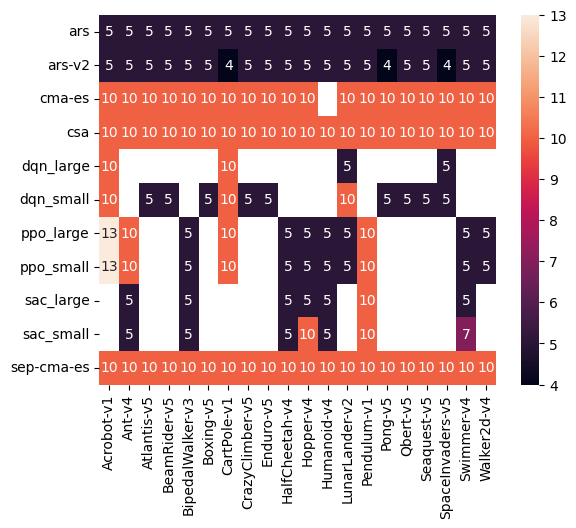

In [69]:
pv = summary[["count", "env"]].pivot(columns=["env"])
sns.heatmap(pv, annot=True)

x, labels = plt.xticks()
labels = [l.get_text()[6:] for l in labels]
plt.xticks(x, labels)
plt.xlabel(None)
plt.ylabel(None);

,count,mean,std,min,25%,50%,75%,max,env,n_timesteps
method,,,,,,,,,,
ars,5.0,-69.80,2.949576,-72.5,-72.500,-70.00,-68.50,-65.5,Acrobot-v1,500000.0
ars-v2,5.0,-69.70,0.908295,-71.0,-70.000,-69.50,-69.50,-68.5,Acrobot-v1,500000.0
cma-es,10.0,-73.15,6.169144,-84.0,-76.750,-70.25,-69.25,-65.0,Acrobot-v1,500000.0
csa,10.0,-75.20,2.496664,-80.5,-75.500,-74.75,-74.00,-71.5,Acrobot-v1,500000.0
dqn_large,10.0,-65.10,3.238655,-69.0,-67.875,-65.50,-62.00,-61.0,Acrobot-v1,500000.0
...,...,...,...,...,...,...,...,...,...,...
ars-v2,5.0,814.00,19.493589,800.0,800.000,800.00,830.00,840.0,Seaquest-v5,20000000.0
cma-es,10.0,916.00,104.902071,840.0,860.000,870.00,910.00,1120.0,Seaquest-v5,20000000.0
csa,10.0,939.00,212.835356,780.0,840.000,840.00,930.00,1470.0,Seaquest-v5,20000000.0


In [1]:
max_reward = pd.DataFrame()

    
f, axes = plt.subplots(2, 3, figsize=(13, 7))


from scipy.signal import savgol_filter
# summary = pd.DataFrame()
handles, labels = [], []
for i, ((env_name, min_timesteps), ax) in enumerate(zip((
    ("CartPole-v1", 5e5),
    ("LunarLander-v2", 5e5),
    ("Swimmer-v4", 5e5),
    ("HalfCheetah-v4", 3e6),
    ("Boxing-v5", 2e7),
    ("SpaceInvaders-v5", 2e7),
), axes.T.ravel())):
    # print(env_name)
    data = rl_data[rl_data.env == env_name]
    try: 
        data = pd.concat([data, pd.read_pickle(f"../data/{env_name}/data_hyp.pkl")])
    except:
        # continue
        data = pd.concat([data, pd.read_pickle(f"../data/{env_name}/data.pkl")])
    
    for label, group in data.groupby("method"):
        time = np.linspace(0, min(min_timesteps, group[time_measure].max()), 1000)
        line = []
        for _, run in group.groupby("run"):
            line.append(np.interp(time, run[time_measure], run.test))

        line = np.median(line, axis=0)
        line = savgol_filter(line, 51, 3)
        std = np.std(line, axis=0)

        lb, ub = get_bounds(env_name)
        
        p = ax.fill_between(time, np.maximum(line - std, lb), np.minimum(ub, line + std), alpha=.2, color=col[label])
        ax.plot(time, line, linewidth=3, color="white", alpha=.8)
        if label == 'ars':
            label += '-v1'
        ax.plot(time, line, linewidth=2, color=p.get_facecolor()[0][:3], label=pretty(label), alpha=.8)


    asummary = data[data.n_train_timesteps < min_timesteps].groupby(["run", "method"])['test'].max().groupby("method").describe()
    
    asummary['env'] = env_name
    asummary['n_timesteps'] = min_timesteps
    summary = pd.concat([summary, asummary])
    ax.set_title(env_name, fontsize=16)
    ax.grid()
    # ax.legend()

    if i in {0, 1}:
        ax.set_ylabel("episodic return", fontsize=15)
    
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if i % 2 == 1:
        ax.set_xlabel(' '.join(time_measure.split("_")), fontsize=15)

    for h, l in zip(*ax.get_legend_handles_labels()):
        if l in labels: continue
        handles.append(h)
        labels.append(l)
    

es = {
     'CMA-ES': 2,
     'CSA-ES': 1,
     'sep-CMA-ES': 3
}

order = sorted(range(len(labels)), key=lambda x: es.get(labels[x]) or 4)
plt.tight_layout(h_pad=-1.)
lgd = ax.legend(
    [handles[idx] for idx in order], 
    [labels[idx] for idx in order], 
    ncol=11, 
    bbox_to_anchor=(1., -.2),
    fancybox=True, 
    framealpha=1,
    fontsize=9.5
)     
plt.savefig("../figures/all_envs1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

NameError: name 'pd' is not defined

In [8]:
data

,env,method,run,n_train_timesteps,test,sigma0,lambda,generation,n_train_episodes,train,expected_test
0,Seaquest-v5,ars,1,97700,60.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Seaquest-v5,ars,1,267330,120.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Seaquest-v5,ars,1,377580,120.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Seaquest-v5,ars,1,442170,180.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Seaquest-v5,ars,1,507450,180.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4285,NaN,sep-cma-es,9,28160132,540.0,1.0,27.0,695.0,19460.0,820.0,540.0
4286,NaN,sep-cma-es,9,28403997,800.0,1.0,27.0,700.0,19600.0,840.0,800.0
4287,NaN,sep-cma-es,9,28641428,820.0,1.0,27.0,705.0,19740.0,820.0,820.0
4288,NaN,sep-cma-es,9,28881591,820.0,1.0,27.0,710.0,19880.0,820.0,820.0


<Axes: xlabel='n_train_timesteps'>

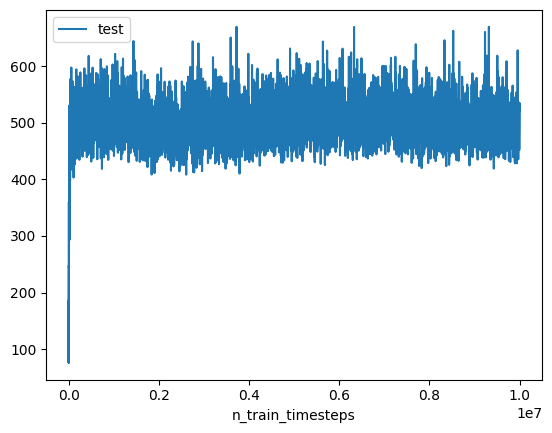

In [44]:
rl_data.query("method == 'ars' and env == 'Humanoid-v4' and run == 4").plot(x="n_train_timesteps", y="test")